In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import sparse

# Homework 3

Anime Recommendations Database from Kaggle: https://www.kaggle.com/CooperUnion/anime-recommendations-database

Read raw data

In [2]:
anime_ratings_df = pd.read_csv("rating.csv")

In [3]:
anime_ratings_df 

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [4]:
anime_ratings = anime_ratings_df.loc[anime_ratings_df.rating != -1].reset_index()[['user_id','anime_id','rating']]

In [5]:
def encode_column(column):
    """ Encodes a pandas column with continous IDs"""
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

In [6]:
def encode_df(anime_df):
    """Encodes rating data with continuous user and anime ids"""
    
    anime_ids, anime_df['anime_id'], num_anime = encode_column(anime_df['anime_id'])
    user_ids, anime_df['user_id'], num_users = encode_column(anime_df['user_id'])
    return anime_df, num_users, num_anime, user_ids, anime_ids

In [7]:
anime_ratings = anime_ratings.reset_index()[['user_id', 'anime_id', 'rating']]

In [8]:
anime_df, num_users, num_anime, user_ids, anime_ids = encode_df(anime_ratings)
print("Number of users :", num_users)
print("Number of anime :", num_anime)
anime_df.head()

Number of users : 69600
Number of anime : 9927


,user_id,anime_id,rating
0,0,0,10
1,0,1,10
2,0,2,10
3,0,3,10
4,1,4,10


In [9]:
anime_df.shape

(6337241, 3)

In [10]:
def create_sparse_matrix(df, rows, cols, column_name="rating"):
    """ Returns a sparse utility matrix""" 
    return sparse.csc_matrix((df[column_name].values,(df['user_id'].values, df['anime_id'].values)),shape=(rows, cols))

In [11]:
anime_df, num_users, num_anime, user_ids, anime_ids = encode_df(anime_ratings)
Y = create_sparse_matrix(anime_df, num_users, num_anime)

In [12]:
Y.shape

(69600, 9927)

In [13]:
Y.todense()

matrix([[10, 10, 10, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 6,  0,  9, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 9,  0,  9, ...,  0,  0,  0],
        [ 9,  0,  0, ...,  0,  0,  0]], dtype=int64)

## Dimension reduction using Non-Negative Matrix Factorization (NMF)

In [14]:
from sklearn.decomposition import NMF
model = NMF(n_components=100, init='random', random_state=0)
W = model.fit_transform(Y)
H = model.components_

C:\Users\tamim\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [15]:
W.shape

(69600, 100)

In [16]:
#anime represntation
H.shape

(100, 9927)

In [17]:
W

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.37984928e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.55186701e-02, 1.01088410e-01, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.53455253e-01, 0.00000000e+00, ...,
        8.87324598e-03, 1.43883392e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## (Optional) Collaborative Filtering based on similarity (10 points)

In [18]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(W)
distances, indices = knn.kneighbors(W, n_neighbors=3)

In [19]:
indices

array([[    0, 45479, 66267],
       [    1,   631, 11189],
       [    2, 53482, 36300],
       ...,
       [69597, 44606, 24912],
       [69598, 51777, 28773],
       [69599, 20011, 25707]], dtype=int64)

In [20]:
distances

array([[2.22044605e-16, 2.56371249e-02, 4.21064832e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.75623893e-01, 3.14049903e-01],
       ...,
       [0.00000000e+00, 5.58742756e-04, 6.30873307e-04],
       [0.00000000e+00, 1.84613721e-01, 1.96927209e-01],
       [0.00000000e+00, 4.69525062e-02, 4.69525062e-02]])

## Supervised learning

In [21]:
anime_df.shape

(6337241, 3)

In [22]:
df = anime_df.sample(n=10000, random_state=1)

In [23]:
train_idx, test_idx = train_test_split(df, test_size=0.2)

In [24]:
W[0,:].shape

(100,)

In [25]:
H[:,0].shape

(100,)

In [26]:
M = np.array(Y.todense())

In [27]:
M

array([[10, 10, 10, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 6,  0,  9, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 9,  0,  9, ...,  0,  0,  0],
       [ 9,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [28]:
def create_features(vec):
    user, item = vec
    X = np.concatenate([W[user,:],H[:,item]])
    return pd.Series(X)

In [29]:
train_X, train_y = train_idx.apply(lambda x: create_features(x[['user_id','anime_id']]), axis = 1), train_idx['rating']

In [30]:
test_X, test_y = test_idx.apply(lambda x: create_features(x[['user_id','anime_id']]), axis = 1), test_idx['rating']

In [31]:
train_X.shape

(8000, 200)

In [32]:
train_y.shape

(8000,)

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
GradientBoostingRegressor().fit(train_X, train_y)

GradientBoostingRegressor()

In [34]:
anime_profile = pd.read_csv("anime.csv")

In [35]:
anime_profile['anime_id'].min()

1

In [36]:
anime_df['anime_id'].min()

0

In [37]:
def create_feature_with_anime_profile(vec):
    user, item = vec 
    X = np.concatenate([W [user,:], H[:,item]], )
    return pd.Series(X)

### 1.1 train a linear regression model to predict ratings (20 points)

### training

In [72]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_X, train_y)
lr.score(train_X, train_y)

0.17877047126833234

### testing

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [39]:
param_grid = {}

In [40]:
grid = GridSearchCV(LinearRegression(),param_grid, return_train_score = True )
grid.fit(train_X, train_y)

GridSearchCV(estimator=LinearRegression(), param_grid={},
             return_train_score=True)

In [41]:
from sklearn.model_selection import cross_validate
cross_validate(LinearRegression(), train_X, train_y)

{'fit_time': array([0.03491497, 0.03494191, 0.03340149, 0.0340476 , 0.03577089]),
 'score_time': array([0.00300622, 0.00153995, 0.00300336, 0.00199986, 0.00201106]),
 'test_score': array([0.17229979, 0.13393663, 0.13056784, 0.13944544, 0.10119501])}

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
cross_validate(GradientBoostingRegressor(), train_X, train_y)

{'fit_time': array([9.54976559, 9.49917603, 9.64905214, 9.49543118, 9.44796276]),
 'score_time': array([0.00502729, 0.00400066, 0.00442505, 0.00452113, 0.00399995]),
 'test_score': array([0.21512483, 0.17951512, 0.18340104, 0.186233  , 0.18967317])}

In [43]:
grid.best_score_

0.13548894072453171

In [44]:
grid.score(train_X, train_y)

0.17877047126833234

## Unsupervised learning

### 1.2 train a k-means model to predict ratings (20 points)

### training 

In [45]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 5, random_state = 0)
km.fit(train_X)

KMeans(n_clusters=5, random_state=0)

In [46]:
train_X.shape

(8000, 200)

In [47]:
km.labels_

array([4, 4, 4, ..., 0, 3, 4])

In [48]:
train_idx

,user_id,anime_id,rating
5431491,58475,1289,9
6023943,65568,1351,9
3604341,39778,1126,10
24295,329,408,7
1377117,15518,791,10
...,...,...,...
97374,1163,1541,6
5767102,62742,94,7
548338,6062,253,7
2332588,25364,909,6


In [49]:
average = []

for i in range(5):
    print(np.mean(train_y[km.labels_ == i]))
    average.append(np.mean(train_y[km.labels_ ==i]))

7.271758436944938
9.533333333333333
8.871794871794872
8.588235294117647
7.845104990455413


In [50]:
inertia = []
for k in range(5, 100, 5):
    km = KMeans(n_clusters =k, random_state=0)
    km.fit(train_X)
    print(km.inertia_)
    inertia.append(km.inertia_)

4717283.6873032665
3757382.0596363405
3071441.745622412
2521559.026686525
2078533.2308191054
1797614.6999539593
1554722.8157978635
1342664.1881938083
1213388.751124936
1085122.202171503
978284.4961842522
877479.4385535169
806302.9809201491
748177.6012665693
703580.1547067838
659869.0199950206
623974.0179027126
591668.6516741168
560130.7121760588


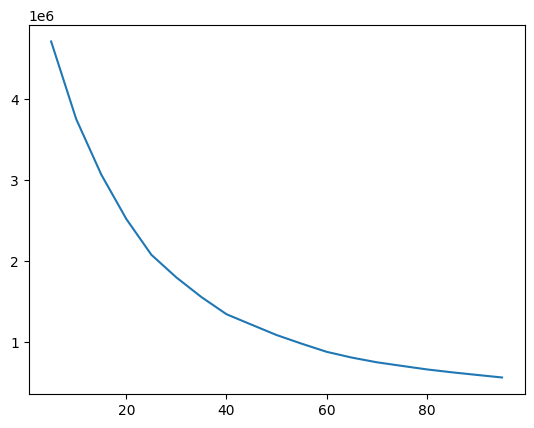

In [51]:
import matplotlib.pyplot as plt
plt.plot(range(5,100,5), inertia)

In [52]:
km = KMeans(n_clusters = 20, random_state = 0)
km.fit(train_X)

KMeans(n_clusters=20, random_state=0)

In [53]:
km.labels_

array([ 1,  1, 10, ...,  9, 19,  1])

In [54]:
average = []

for i in range(20):
    print(np.mean(train_y[km.labels_ == i]))
    average.append(np.mean(train_y[km.labels_ ==i]))

8.707317073170731
7.796041596779604
8.45
8.871794871794872
8.891891891891891
9.533333333333333
8.487179487179487
8.102564102564102
9.10958904109589
7.221393034825871
7.765503875968992
7.384615384615385
9.119047619047619
7.9411764705882355
8.363636363636363
7.9375
8.472222222222221
7.972972972972973
8.24390243902439
8.142857142857142


### testing

In [55]:
km.predict(test_X)

array([1, 1, 1, ..., 1, 1, 1])

In [56]:
km.predict(test_X).max()

19

In [57]:
pred = []
for i in km.predict(test_X):
    pred.append(average[i])

In [58]:
from sklearn.metrics import r2_score
r2_score(test_y, pred)

0.013348601039691377

### Pick one of the above, then

### 1.3 Test on unknown data. Predict the rating of user_id == 1 on anime_id==1. (10 points)

In [73]:
# For LR, construct features X
X = np.array(create_features([1,1])).reshape(1,-1)

In [74]:
pred = lr.predict(X)
pred[0]

7.381852325445037

### 1.4 Visualization (10 points)

In [ ]:
from sklearn.manifold import TSNE
train_X_tsne = TSNE().fit_transform(train_X)
plt.scatter(train_X_tsne[:,0], train_X_tsne[:,1], c = train_y)
plt.title("t_SNEvembedding of digits")
plt.xticks()
plt.yticks()

In [ ]:
from sklearn.manifold import TSNE
train_X_tsne = TSNE().fit_transform(Y[:8000,])
plt.scatter(train_X_tsne[:,0], train_X_tsne[:,1], c = train_y)
plt.title("t_SNEvembedding of digits")
plt.xticks()
plt.yticks()

In [ ]:
from sklearn.manifold import TSNE
W_tsne = TSNE().fit_transform(W)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(W_tsne[:, 0], W_tsne[:, 1])
plt.title("t_SNE embedding of users")
plt.xticks(())
plt.yticks(())

In [ ]:
H_tsne = TSNE().fit_transform(np.transpose(H))

In [ ]:
plt.scatter(H_tsne[:,0], H_tsne[:,1])
plt.title("t_SNE embedding of digits")
plt.xticks()
plt.yticks()